## Test the Stability of the Model Removing ML4 from training dataset
In this experiment, we check the stability of the model by performing the following experiments: 
1. Remove 5%, 10%, 20%, 30%, and 50% of data randomly from the training set and evaluate the testing performance

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pickle import load, dump

sys.path.insert(0, '../')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
from sklearn.metrics import r2_score

from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, perform_combat_normalization
from src.load_models import select_model
from src.graph_visualization import visualization_testing_dataset
from src.config import *

In [2]:
# Load dataset
normalization    = True
standardize_type = 'mean_std' if normalization else 'none'
split            = True
combat_norm      = False

if split:
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split)
    (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split)

else:
    ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split)
    ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split)
    ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split)

######Data Distribution:#########
Training {0: 27, 8: 25, 16: 26}
Testing {16: 18, 0: 17, 8: 17}
#################################
######Data Distribution:#########
Training {0: 24, 8: 21, 16: 24}
Testing {0: 16, 16: 16, 8: 15}
#################################
######Data Distribution:#########
Training {0: 23, 8: 25, 16: 21}
Testing {0: 15, 8: 16, 16: 15}
#################################


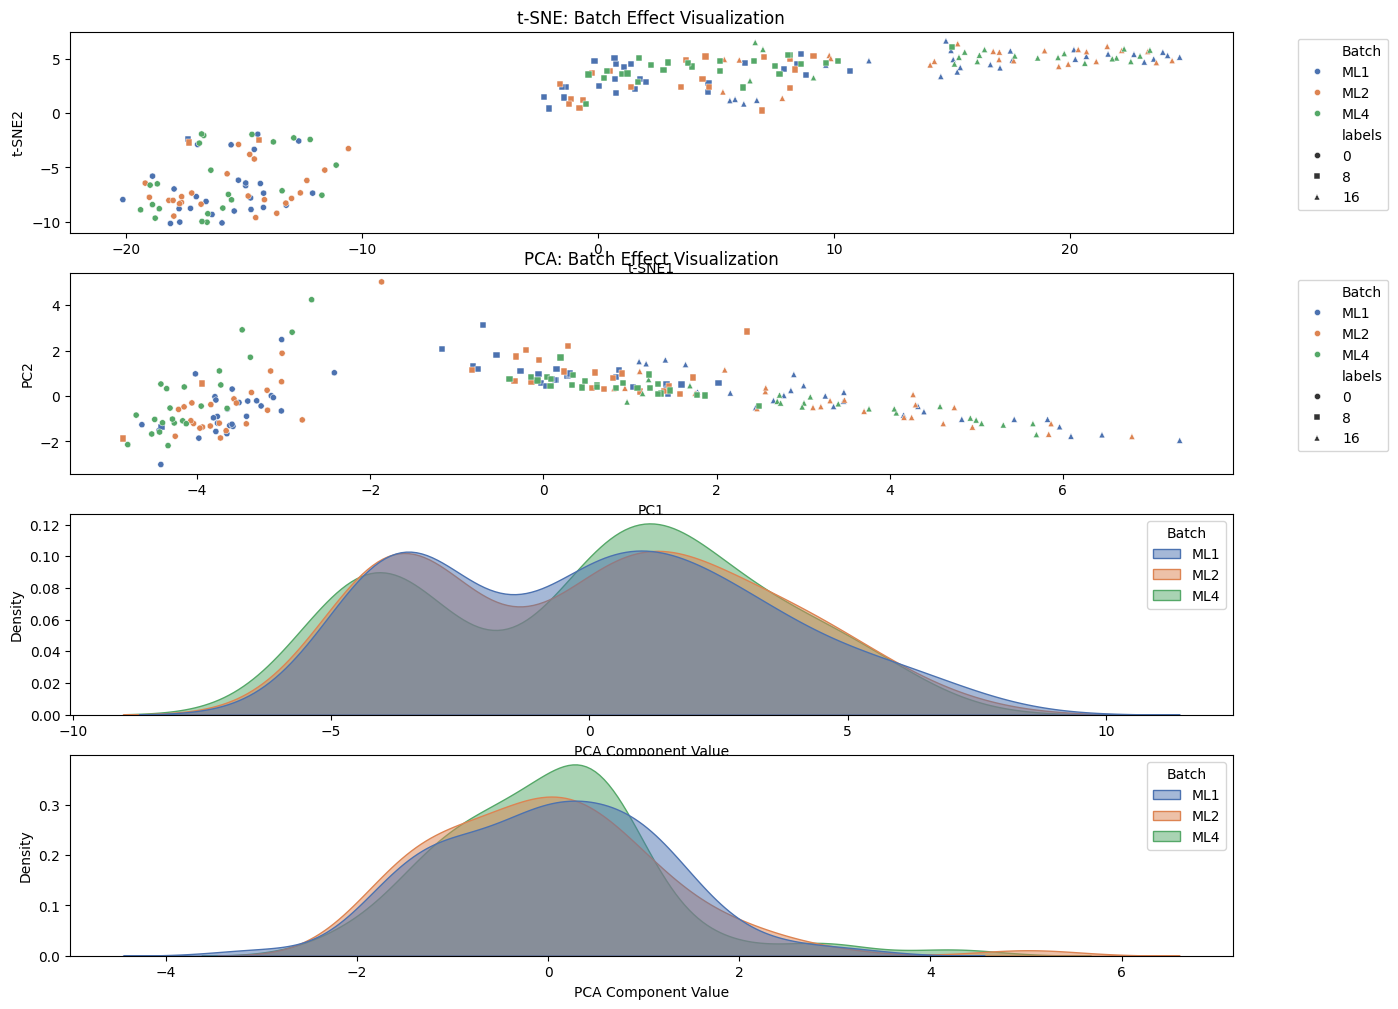

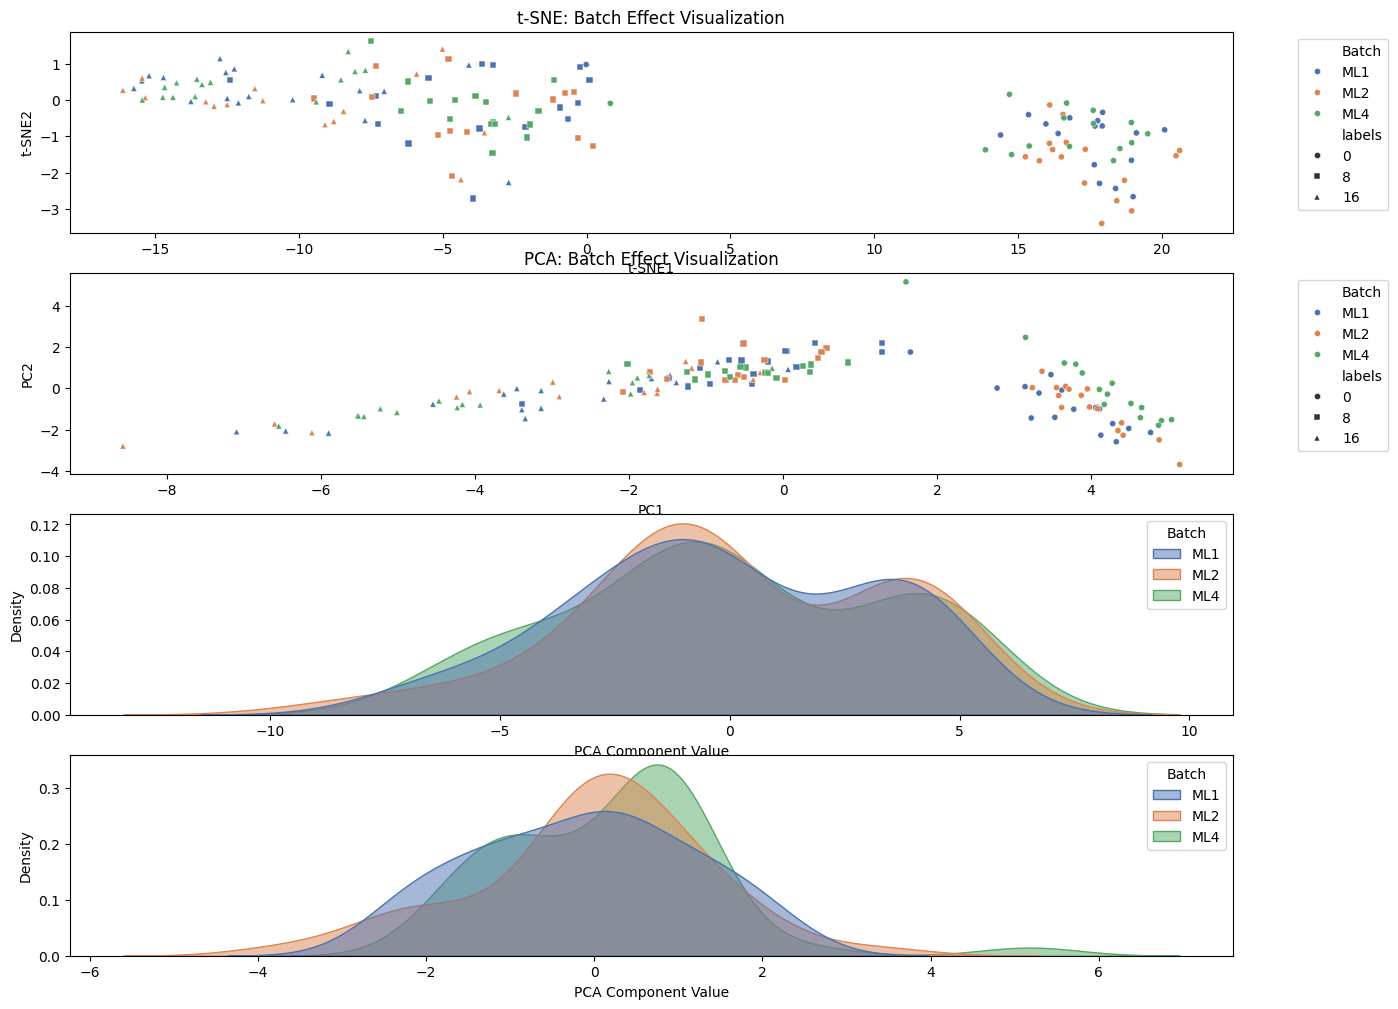

In [3]:
# Visualize PCA and t-SEN
data_train          = pd.concat([ML1_X_train, ML2_X_train, ML4_X_train])
batch_labels_train  = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X_train), len(ML2_X_train), len(ML4_X_train)])
batch_labels_test   = np.repeat(['ML1', 'ML2', 'ML4'], repeats= [len(ML1_X_test),  len(ML2_X_test),  len(ML4_X_test)])

labels_train = ML1_y_train.values.tolist() + ML2_y_train.values.tolist() + ML4_y_train.values.tolist()
labels_test  = ML1_y_test.values.tolist()  + ML2_y_test.values.tolist()  + ML4_y_test.values.tolist()

tsen_pca_viz([ML1_X_train, ML2_X_train, ML4_X_train], batch_labels_train, labels_train)
tsen_pca_viz([ML1_X_test,  ML2_X_test,  ML4_X_test],  batch_labels_test,  labels_test)

In [7]:
# perform stratified train test split
def create_training_dataset(per_remove):
    
    num_ML4          = int(len(ML4_X_train)*(1 - per_remove))
    selected         = np.random.choice(range(len(ML4_X_train)), num_ML4, replace=False)
    ML4_X_train_temp = ML4_X_train.iloc[selected].copy()
    ML4_y_train_temp = ML4_y_train.iloc[selected].copy()

    assert len(ML4_y_train_temp) == num_ML4

    y_train_strat = ML1_y_train.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y_train.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y_train_temp.map(lambda x: f'ML4_{x}').values.tolist()
    y_test_strat  = ML1_y_test.map(lambda x:  f'ML1_{x}').values.tolist() + ML2_y_test.map(lambda x: f'ML2_{x}').values.tolist()  + ML4_y_test.map(lambda x: f'ML4_{x}').values.tolist()

    # Combine ML1, ML2, and ML4 dataset
    X_train, X_test, y_train, y_test =  pd.concat([ML1_X_train, ML2_X_train, ML4_X_train_temp], axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_X_test,  ML2_X_test,  ML4_X_test],  axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_y_train, ML2_y_train, ML4_y_train_temp], axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_y_test,  ML2_y_test,  ML4_y_test],  axis=0).reset_index(drop=True)

    # Create shuffling index with random choice
    shuffle_ind_train = np.random.choice(range(len(X_train)), len(X_train), replace=False)
    assert len(np.unique(shuffle_ind_train))==len(X_train)
    
    shuffle_ind_test = np.random.choice(range(len(X_test)), len(X_test), replace=False)
    assert len(np.unique(shuffle_ind_test))==len(X_test)

    # Shuffle training dataset
    X_train, y_train = X_train.iloc[shuffle_ind_train], y_train.iloc[shuffle_ind_train]
    X_test,  y_test  = X_test.iloc[shuffle_ind_test],   y_test.iloc[shuffle_ind_test]

    # Check if the labels and features have same index after shuffling
    assert X_train.index.tolist()==y_train.index.tolist()
    assert X_test.index.tolist()==y_test.index.tolist()

    return X_train, X_test, y_train, y_test

In [8]:
def plot_scores_distribution(scores, model_name, adj_score=False):
    scores = scores.copy()
    if type(scores[0][model_name][0])==tuple:
        for data_per_remove in per_to_remove:
            scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:,(1 if adj_score else 0)]
    for data_per_remove in per_to_remove:
        sns.kdeplot(scores[data_per_remove][model_name], label=f'{data_per_remove}%')
    
    plt.legend(title='Parameter', title_fontsize='13')
    plt.show()


def training_reduction_plot(scores, model_names, filename, title, r2=True, adj_score=False, save=True):

    min_, max_ = (0.70 if r2 else 10), (0.9 if r2 else 60)
    
    for model_name in model_names:
        data = []
        if type(scores[0][model_name][0])==tuple:
            for data_per_remove in per_to_remove:
                scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:,(1 if adj_score else 0)]
    
        for data_per_remove in per_to_remove:
            data.append(np.array(scores[data_per_remove][model_name]).mean())
            
        # plt.ylim(bottom=min_, top=max_)
        plt.plot(data, label=model_name, marker='o')
        plt.xticks(ticks=range(len(per_to_remove)), labels=[f'{i}%' for i in per_to_remove])
        plt.legend()

    os.makedirs('../results/training_reduction_plot', exist_ok = True)
    plt.title(title)
    if save:
        plt.savefig(f'../results/training_reduction_plot/{filename}.png', dpi=300)
    plt.show()

def box_plot(scores, model_names, adj_score=False):
    os.makedirs('../results/box_plot', exist_ok=True)
    for model_name in model_names:
        data = pd.DataFrame(columns=['scores', 'per_remove'])
    
        for data_per_remove in per_to_remove:
            if type(scores[data_per_remove][model_name][0])==tuple:
                scores[data_per_remove][model_name] = np.array(scores[data_per_remove][model_name])[:, (1 if adj_score else 0)]
                
            temp = pd.DataFrame({'scores':np.array(scores[data_per_remove][model_name]).tolist(), 'per_remove':[f'{data_per_remove}%']*len(scores[data_per_remove][model_name])})
            data = pd.concat([data, temp], axis=0)

        
        ax = sns.boxplot(x='per_remove', y='scores', data=data, showfliers=False)
        # print(list())
        for i, per in enumerate(per_to_remove):
            
            y  = data[data['per_remove'] ==f'{per}%']['scores']
            var = y.var()

            print(var)

            q1 = np.percentile(y, 25)
            q3 = np.percentile(y, 75)

            min_ = q1 - (q3 - q1)*1.5
            
            ax.text(i, min_ - 0.004, f'{var:.1e}', ha='center', color='black')
        
        plt.ylim(bottom=0.80, top=0.90)
        plt.title(f'{model_name}')
        plt.savefig(f'../results/box_plot/{model_name}.png', dpi=300)
        plt.show()

In [10]:
# List of models
load_locally = False
r2_score_val,  per_diff_val  = {}, {}
r2_score_test, per_diff_test = {}, {}
r2_train_scores, per_diff_train_scores = {}, {}

# models        = ['Linear', 'KNN', 'SVM', 'RF', 'GP', 'Ridge', 'Lasso', 'univariate, std(S)', 'univariate, max(dS/dV)']
models = ['RF']
per_to_remove = [0, 5, 10, 20, 30, 50]
num_iteration = 100

# Calcualte y_LOD
y_LOD = 0.9117010154341669 #calculate_y_LOD(X_testing, y_testing)


kf = KFold(n_splits=5)

if load_locally:
    with open('../weights/r2_score_val.pickle', 'rb') as f:
        r2_score_val = load(f)

    with open('../weights/per_diff_val.pickle', 'rb') as f:
        per_diff_val = load(f)
    
    with open('../weights/r2_score_test.pickle', 'rb') as f:
        r2_score_test = load(f)
    
    with open('../weights/per_diff_test.pickle', 'rb') as f:
        per_diff_test = load(f)

    raise KeyboardInterrupt


for data_per_remove in per_to_remove:
    r2_score_val[data_per_remove], per_diff_val[data_per_remove], r2_score_test[data_per_remove], per_diff_test[data_per_remove] = {}, {}, {}, {} 
    r2_train_scores[data_per_remove], per_diff_train_scores[data_per_remove] = {}, {}
    
    for model_name in models:
        r2_score_val[data_per_remove][model_name]          = []
        per_diff_val[data_per_remove][model_name]          = [] 
        r2_score_test[data_per_remove][model_name]         = [] 
        per_diff_test[data_per_remove][model_name]         = [] 
        r2_train_scores[data_per_remove][model_name]       = []
        per_diff_train_scores[data_per_remove][model_name] = []
        
for data_per_remove in tqdm(per_to_remove):
    for _ in range(num_iteration):
        X_train, X_test, y_train, y_test = create_training_dataset(data_per_remove)
       
        for model_name in models:
            model    = select_model(model_name)
        
            val_r2     = calculate_r2_score(model, X_train[models_features_r2[model_name]],  y_train, kf)
            val_per    = calculate_per_diff(model, X_train[models_features_per[model_name]], y_train, kf, y_LOD)
        
            r2_score_val[data_per_remove][model_name].append((float(val_r2[0]), float(val_r2[1])))
            per_diff_val[data_per_remove][model_name].append(float(val_per))
        
            model_r2  = clone(model)
            model_r2.fit(X_train[models_features_r2[model_name]], y_train)
            y_pred_train_r2 = model_r2.predict(X_train[models_features_r2[model_name]])
            y_pred_r2       = model_r2.predict(X_test[models_features_r2[model_name]])

            r2_train_score  = r2_score(y_train, y_pred_train_r2)
            r2_test_score   = r2_score(y_test, y_pred_r2)
            adj_r2_test     = find_adj_score(len(y_pred_r2), len(models_features_r2[model_name]), r2_test_score)
            adj_r2_train    = find_adj_score(len(y_pred_train_r2), len(models_features_r2[model_name]), r2_train_score)

            r2_train_scores[data_per_remove][model_name].append((float(r2_train_score), float(adj_r2_train)))
            r2_score_test[data_per_remove][model_name].append((float(r2_test_score), float(adj_r2_test)))
        
            model_per_diff = clone(model)
            model_per_diff.fit(X_train[models_features_per[model_name]], y_train)

            y_train_per_diff = model_per_diff.predict(X_train[models_features_per[model_name]])
            y_pred_per_diff  = model_per_diff.predict(X_test[models_features_per[model_name]])

            per_diff_train_scores[data_per_remove][model_name].append(per_error(y_train, y_train_per_diff, y_LOD))
            per_diff_test[data_per_remove][model_name].append(per_error(y_test, y_pred_per_diff, y_LOD))


  0%|                                                                                                                          | 0/6 [00:59<?, ?it/s]

KeyboardInterrupt



In [ ]:
plt.show()

In [ ]:
per_to_remove = [0, 5, 10, 20, 30, 50]
save          = False

model_names_to_test = models#['Linear', 'SVM', 'RF', 'KNN', 'GP', 'univariate, std(S)', 'univariate, max(dS/dV)']
training_reduction_plot(r2_score_val.copy(),  model_names_to_test, f'r2_score_val_{normalization}', title='R2 score Validation', adj_score=True, save=save)
training_reduction_plot(r2_score_test.copy(), model_names_to_test, f'r2_score_test_{normalization}',title='R2 score Testing', adj_score=True, save=save)
training_reduction_plot(r2_train_scores.copy(), model_names_to_test, f'r2_score_train_{normalization}',title='R2 score Training', adj_score=True, save=save)

In [ ]:
training_reduction_plot(per_diff_val.copy(),  model_names_to_test, f'per_diff_val_{normalization}',title='Percent Error Validation', adj_score=True, save=save)
training_reduction_plot(per_diff_test.copy(), model_names_to_test, f'per_diff_test_{normalization}',title='Percent Error Testing',  adj_score=True, save=save)
training_reduction_plot(per_diff_train_scores.copy(), model_names_to_test, f'per_diff_train_{normalization}',title='Percent Error Training',adj_score=True, save=save)

In [ ]:
plt.clf()

In [ ]:
per_to_remove = [0, 5, 10, 20, 30, 50]
box_plot(r2_score_test.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'], adj_score=True)

In [ ]:
training_reduction_plot(per_diff_val.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])
training_reduction_plot(per_diff_test.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])

In [ ]:
box_plot(per_diff_test.copy(), ['Linear', 'SVM', 'RF', 'KNN', 'GP'])

In [ ]:
plot_scores_distribution(r2_score_test.copy(), 'GP')
# plot_scores_distribution(r2_score_val.copy(), 'SVM')
# plot_scores_distribution(r2_score_val.copy(), 'RF')
# plot_scores_distribution(r2_score_val.copy(), 'KNN')

In [ ]:
# Plot KDEs with labels
model_name = 'RF'
sns.kdeplot(np.array(r2_score_test[5][model_name])[:,0], label='5%', color='r')
sns.kdeplot(np.array(r2_score_test[10][model_name])[:,0], label='10%', color='b')
sns.kdeplot(np.array(r2_score_test[20][model_name])[:,0], label='20%', color='g')
sns.kdeplot(np.array(r2_score_test[30][model_name])[:,0], label='30%', color='m')

# Add legend
plt.legend(title='Parameter', title_fontsize='13')

In [ ]:
sns.kdeplot(per_diff_test[5]['KNN'])
sns.kdeplot(per_diff_test[10]['Linear'])
sns.kdeplot(per_diff_test[20]['Linear'])
sns.kdeplot(per_diff_test[30]['Linear'])

In [ ]:
# r2_score_val,  per_diff_val  = {}, {}
# r2_score_test, per_diff_test
with open('../weights/r2_score_val.pickle', 'wb') as f:
    dump(r2_score_val, f)

with open('../weights/per_diff_val.pickle', 'wb') as f:
    dump(per_diff_val, f)

with open('../weights/r2_score_test.pickle', 'wb') as f:
    dump(r2_score_test, f)

with open('../weights/per_diff_test.pickle', 'wb') as f:
    dump(per_diff_test, f)

with open('../weights/r2_training_scores.pickle', 'wb') as f:
    dump(r2_training_scores, f)

with open('../weights/per_diff_training_scores.pickle', 'wb') as f:
    dump(per_diff_training_scores, f)

In [ ]:
r2_score_val.keys()

In [ ]:
np.random.choice(range(5), 5,replace=False)

In [ ]:
list(range(5))

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [ ]:
X = np.array([[[1,2,3], [3,4,5]], [[3,4,5], [5,6,7]], [[5,6,7], [6,7,8]], [[6,7,8], [7,6,7]], [[7,6,7],[8,6,6]]])
y = np.array([3, 2, 3, 5, 4, 6])

In [ ]:
# Define the kernel
kernel =  RBF(1.0, (1e-4, 1e1))

# Create and fit the GP model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gp.fit(X, y)